In [1]:
import cv2
import sys
import numpy as np
import argparse
import chainer
from entity import params
from pose_detector import PoseDetector, draw_person_pose
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def select_region(image):
    if len(image.shape) == 3:
        high, wid, ch = image.shape
    else:
        high, wid = image.shape

    # make area
    bottom_left  = [wid*0.1, high*1]
    top_left     = [wid*0.30, high*0.3]
    bottom_right = [wid*0.9, high*1]
    top_right    = [wid*0.7, high*0.3]
    # polygons 
    poly = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, poly, 255)
    else:
        # in case of channel=3
        cv2.fillPoly(mask, poly, (255,)*mask.shape[2])

    return cv2.bitwise_and(image, mask), mask


In [4]:
#load model
pose_detector = PoseDetector("posenet", "models/coco_posenet.npz", device=-1, precise=True)

Loading the model...


In [ ]:
# define crop_person
def crop_person(img, bbox, person_pose):
    unit_length = 
    
    
    left = (left_pos - 0.3 * unit_length).astype(int)
    right = (right_pos + 0.3 * unit_length).astype(int)
    top = (top_pos - top_padding_radio[top_joint_index] * unit_length).astype(int)
    bottom = (bottom_pos + bottom_padding_radio[bottom_joint_index] * unit_length).astype(int)
    bbox = (left, top, right, bottom)

    cropped_img = pose_detector.crop_image(img, bbox)
    return cropped_img



In [ ]:
# crop one image
img = cv2.imread('./data/youtube/img_08304.png')
img, mask = select_region(img)
plt.imshow(img)

# inference
poses, scores = pose_detector(img)

i = 0
unit_length = pose_detector.get_unit_length(poses[i])


In [82]:
# read multi images
for i in range(0,61):    
    print('83{0:02d}'.format(i))
    # read image
    img = cv2.imread('./data/youtube/img_083{0:02d}.png'.format(i))
    # select detection area
    img, mask = select_region(img)
    # inference
    poses, scores = pose_detector(img) # posesはscoreが高い順
    #res_img = cv2.addWeighted(img, 0.6, draw_person_pose(img, poses), 0.4, 0)
    # draw keypoint
    img = draw_person_pose(img, poses)
    # plt.imshow(img)
    
    # compare unit_length 
    unit_0 = pose_detector.get_unit_length(poses[0])
    unit_1 = pose_detector.get_unit_length(poses[1])
    # detect bottom player(0:bottom, 1:top player)
    cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
    if cropped_img_b is not None:
        crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)

    # detect top player
    cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
    if cropped_img is not None:
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)

8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360


In [ ]:
if (unit_0 > unit_1): # (larger=bottom)
        # detect bottom player(0:bottom, 1:top player)
        cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
        if cropped_img_b is not None:
            crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)
        
        # detect top player
        cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
        if cropped_img is not None:
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)
    else:
        print('detect bottom player failed.')    


In [ ]:
# detect bottom player(0:bottom, 1:top player)
cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)

# detect top player
cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)

In [24]:
num_person = poses.shape[0]
# each person detected
for i, pose in enumerate(poses):
    unit_length = pose_detector.get_unit_length(pose)
    # detect person
    cropped_person_img, bbox = pose_detector.crop_person(img, pose, unit_length) 
    #if cropped_person_img is not None:
    #    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
     #   plt.imshow(crop_img)
        

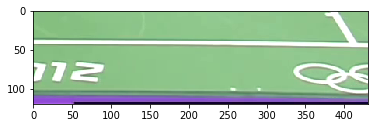

In [25]:
crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
plt.imshow(crop_img)

(744, 131, 1178, 1253)
568.504843645
1122


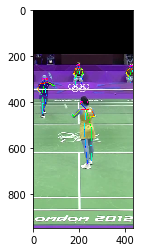

In [27]:
i = 0
# detect person
cropped_person_img, bbox = pose_detector.crop_person(img, poses[i], unit_length) 
if cropped_person_img is not None:
    # cv2.rectangle(res_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), 1)
    print(bbox)
    print(unit_length)
    if (bbox[3]-bbox[1] > 120):
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        plt.imshow(crop_img)
        print(bbox[3] - bbox[1])
    else:
        print(bbox[3] - bbox[1])

<class 'numpy.ndarray'>


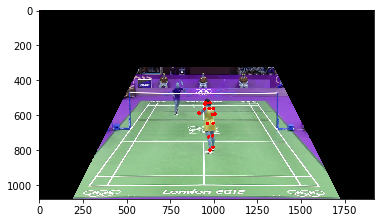

In [11]:
img = cv2.imread('./data/youtube/img_08304.png')
img, mask = select_region(img)
plt.imshow(img)
i = 0
unit_length = pose_detector.get_unit_length(poses[i])
print(type(poses[i]))
for i, pose in enumerate(poses[i].astype(int)):
    img = cv2.circle(img, tuple(pose[0:2]), 10, (255, 0, 0), -1)
plt.imshow(img)

In [1]:
pose = poses[0]
pose[0:2]

NameError: name 'poses' is not defined

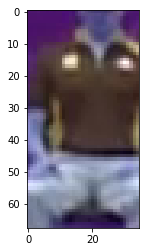

In [82]:
# each person detected
for i, person_pose in enumerate(person_pose_array):
    unit_length = pose_detector.get_unit_length(person_pose)
    # detect person
    cropped_person_img, bbox = pose_detector.crop_person(img, person_pose, unit_length) 
    if cropped_person_img is not None:
         #cv2.rectangle(res_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), 1)
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            plt.imshow(crop_img)
            cv2.imwrite('./data/crop_{0:02d}.png'.format(i), crop_img)